## Loan Prediction System


##### Overview

This project aims to develop an end-to-end Loan Prediction System, including data preprocessing, model development, and deployment. The system predicts whether a loan application should be approved or not based on various factors.

Data source : https://www.kaggle.com/datasets/burak3ergun/loan-data-set


In [40]:
!pip install pandas --quiet
!pip install numpy --quiet
!pip install seaborn --quiet
!pip install scikit-learn --quiet
!pip install pytest-warnings --quiet

In [41]:
# Import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder 
%matplotlib inline

import warnings

### 1. Loading dataset


In [3]:
def load_dataset(file_path):
    """
    Load dataset from a CSV file.

    Parameters:
    file_path (str): The path to the CSV file.

    Returns:
    pd.DataFrame: The loaded dataset.
    """
    try:
        load_data = pd.read_csv(file_path)
        return load_data
    except FileNotFoundError:
        print("File not found. Please provide a valid file path.")
        return None

# Example usage:
file_path = './loan_data_set.csv'
dataset_df = load_dataset(file_path)
if dataset_df is not None:
    dataset_df.head()


### 2. Exploration Data and Analysis - Understanding dataset


In [4]:
# display dataset 
dataset_df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
# Dataset information
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
# The summary statistics of the dataset
dataset_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [7]:
# This function will return a Series containing the count of missing values for each column in `dataset_df`.
def missing_values(data):
    null_values = data.isnull().sum()
    return null_values

missing_values(dataset_df)


Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

##### <ins>Data Cleaning - drop some columns</ins>


In [8]:
# drop loadID and dependents columns
dataset_df.drop(['Loan_ID', 'Dependents'], axis=1, inplace=True)
dataset_df.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


##### <ins>Data Cleaning - fill missing values using modes</ins>


In [9]:
# Fill missing values in these columns with their respective modes.

# Selecting the columns with missing values
selected_columns = ["Gender", "Married", "Self_Employed"]

# Iterating over each selected column
for column_name in selected_columns:
    # Calculating the mode (most frequent value) of the column
    column_mode = dataset_df[column_name].mode().iloc[0]
    
    # Filling missing values in the column with the calculated mode
    dataset_df[column_name] = dataset_df[column_name].fillna(column_mode)


<small>1. Typically used for categorical or ordinal data where values represent categories or levels.</small> <br><small>2. Useful when dealing with categorical variables like gender, marital status, employment status, etc.</small><br>
<small>3. Filling missing values with the mode helps preserve the distribution and frequency of existing categories in the dataset.</small><br>


In [10]:
missing_values(dataset_df)

Gender                0
Married               0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

##### <ins>Data Cleaning - fill missing values using means</ins>


In [11]:
# Fill missing values in these columns with their respective means.

# Selecting the columns with missing values
selected_columns = ["LoanAmount", "Loan_Amount_Term", "Credit_History"]
selected_data = dataset_df[selected_columns]

# Iterating over each selected column
for column_name in selected_columns:
    # Calculating the mean of the column
    column_mean = dataset_df[column_name].mean()
    
    # Filling missing values in the column with the calculated mean
    dataset_df[column_name] = dataset_df[column_name].fillna(column_mean)


In [12]:
dataset_df.isna().sum()

Gender               0
Married              0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

##### <ins>Data visualization - Understanding correlations</ins>


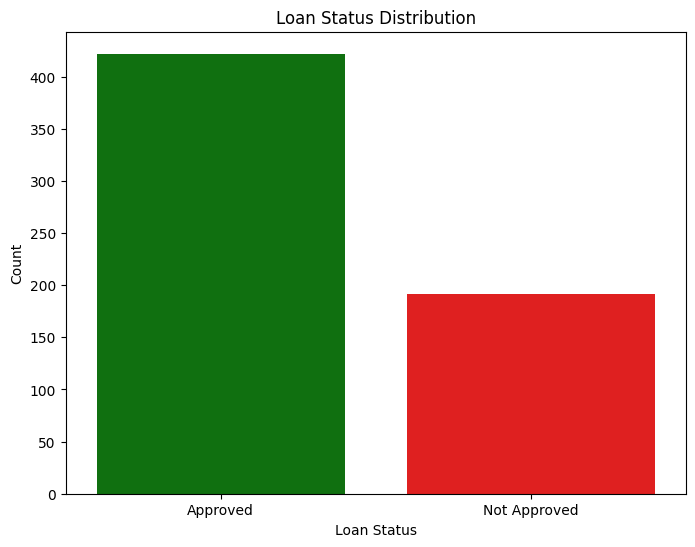

In [13]:

def visualize_loan_status(data):
    # Replace 'Y' with 'Approved' and 'N' with 'Not Approved'
    data['Loan_Status'] = data['Loan_Status'].replace({'Y': 'Approved', 'N': 'Not Approved'})

    # Count plot for Loan_Status with hue assigned to x variable
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Loan_Status', hue='Loan_Status', data=data, palette={'Approved': 'green', 'Not Approved': 'red'}, legend=False)
    plt.title('Loan Status Distribution')
    plt.xlabel('Loan Status')
    plt.ylabel('Count')
    plt.show()

# Call the function with the dataset_df DataFrame
visualize_loan_status(dataset_df.copy())


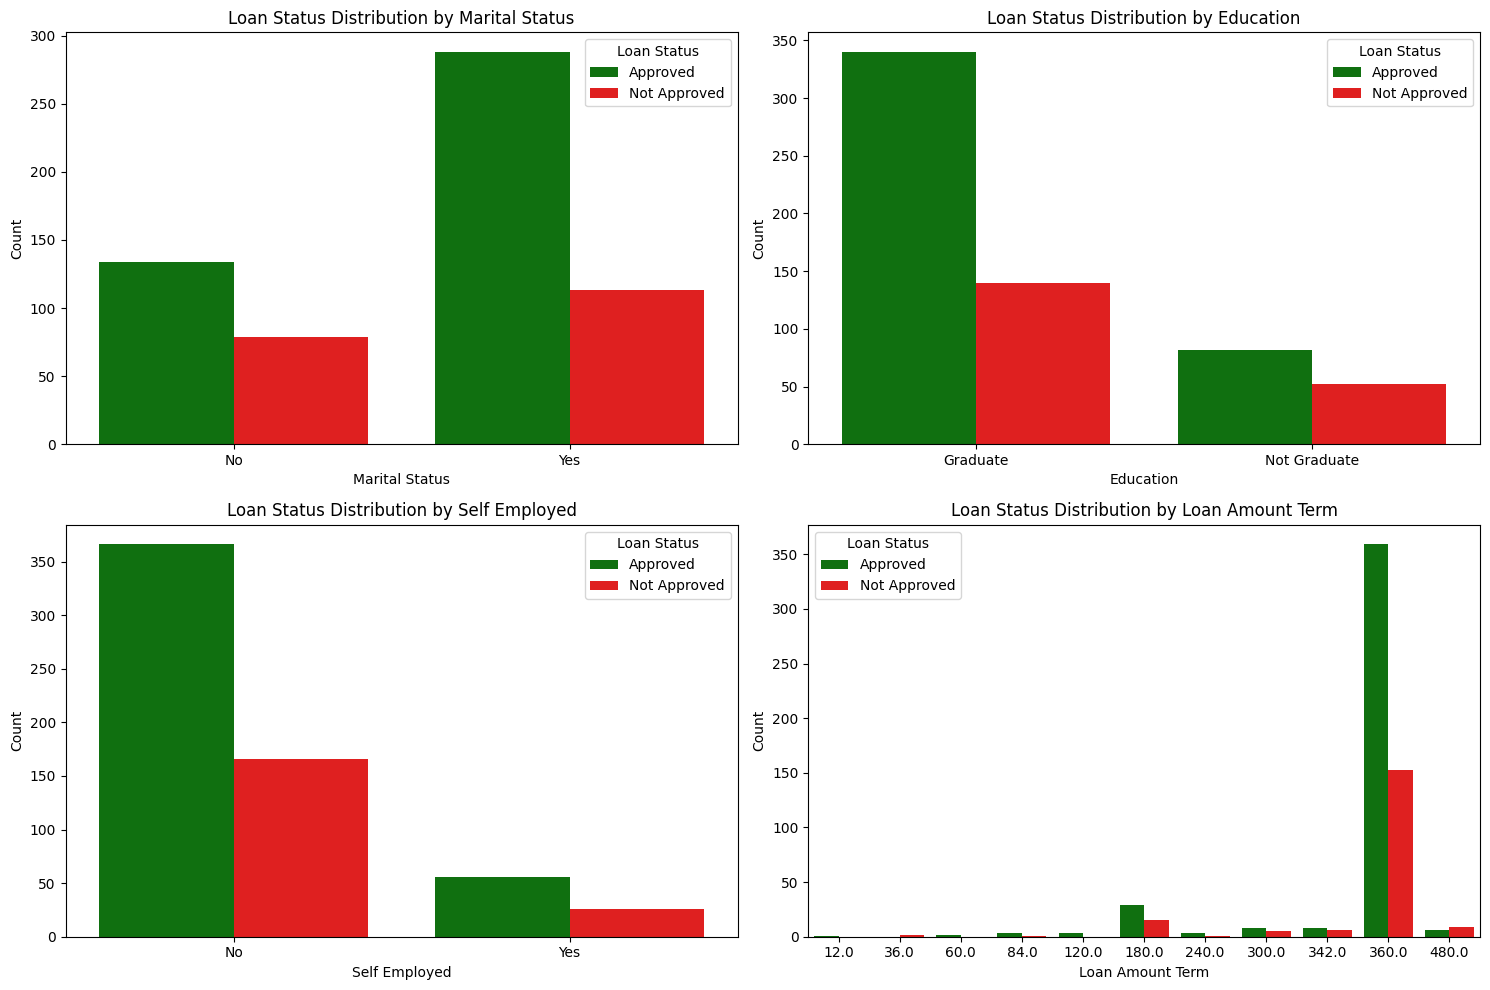

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_loan_status(data):
    # Replace 'Y' with 'Approved' and 'N' with 'Not Approved' in Loan_Status
    data['Loan_Status'] = data['Loan_Status'].replace({'Y': 'Approved', 'N': 'Not Approved'})

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot for Married vs Loan_Status
    sns.countplot(ax=axes[0, 0], x='Married', hue='Loan_Status', data=data, palette={'Approved': 'green', 'Not Approved': 'red'})
    axes[0, 0].set_title('Loan Status Distribution by Marital Status')
    axes[0, 0].set_xlabel('Marital Status')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].legend(title='Loan Status')

    # Plot for Education vs Loan_Status
    sns.countplot(ax=axes[0, 1], x='Education', hue='Loan_Status', data=data, palette={'Approved': 'green', 'Not Approved': 'red'})
    axes[0, 1].set_title('Loan Status Distribution by Education')
    axes[0, 1].set_xlabel('Education')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].legend(title='Loan Status')

    # Plot for Self_Employed vs Loan_Status
    sns.countplot(ax=axes[1, 0], x='Self_Employed', hue='Loan_Status', data=data, palette={'Approved': 'green', 'Not Approved': 'red'})
    axes[1, 0].set_title('Loan Status Distribution by Self Employed')
    axes[1, 0].set_xlabel('Self Employed')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].legend(title='Loan Status')
    
    # Plot for Loan_Amount_Term vs Loan_Status
    sns.countplot(ax=axes[1, 1], x='Loan_Amount_Term', hue='Loan_Status', data=data, palette={'Approved': 'green', 'Not Approved': 'red'})
    axes[1, 1].set_title('Loan Status Distribution by Loan Amount Term')
    axes[1, 1].set_xlabel('Loan Amount Term')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend(title='Loan Status')
    
    plt.tight_layout()
    plt.show()

# Call the function with the dataset_df DataFrame
visualize_loan_status(dataset_df.copy())


##### <ins>Perform categorical encoding</ins>


In [34]:
# List of categorical columns to encode
categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

def encode_categorical_features(data, categorical_columns):
    """
    Encode categorical features using OrdinalEncoder.

    Parameters:
    data (DataFrame): The DataFrame containing the categorical features.
    categorical_columns (list): A list of column names corresponding to the categorical features.

    Returns:
    DataFrame: The DataFrame with categorical features encoded.
    """
    # Initialize the OrdinalEncoder
    ord_enc = OrdinalEncoder() 

    # Fit and transform the selected columns
    data[categorical_columns] = ord_enc.fit_transform(data[categorical_columns])

    return data

In [35]:
# Call the function to encode categorical features
dataset_df_encoded = encode_categorical_features(dataset_df.copy(), categorical_columns)

# Display the first few rows of the transformed DataFrame
dataset_df_encoded.head()


,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1.0,0.0,0.0,0.0,5849,0.0,146.412162,360.0,1.0,2.0,1.0
1,1.0,1.0,0.0,0.0,4583,1508.0,128.000000,360.0,1.0,0.0,0.0
2,1.0,1.0,0.0,1.0,3000,0.0,66.000000,360.0,1.0,2.0,1.0
3,1.0,1.0,1.0,0.0,2583,2358.0,120.000000,360.0,1.0,2.0,1.0
4,1.0,0.0,0.0,0.0,6000,0.0,141.000000,360.0,1.0,2.0,1.0


<small>**Note**: `The OrdinalEncoder` is used when there's an inherent order among categories, and use `one-hot encoding` or `dummy encoding`when categories are nominal (unordered) or when you want to avoid implying any ordinal relationship between categories.<small>


##### <ins>Convert the dataframe in integer format</ins>


In [38]:
#  convert categorical variables in of DataFrame to integer type:

def convert_categorical_to_int(df):

    # Create a copy of the DataFrame to avoid modifying the original data
    modified_df = df.copy()

    # Define the list of categorical columns to be converted
    categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

    # Convert each categorical column to integer type
    for col in categorical_columns:
        # Use astype('category').cat.codes to convert categories to numerical codes
        modified_df[col] = modified_df[col].astype('category').cat.codes

    return modified_df


In [39]:
# Call the function to convert categorical columns to integer type
convert_categorical_to_int(dataset_df_encoded)


,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,5849,0.0,146.412162,360.0,1.0,2,1
1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0
2,1,1,0,1,3000,0.0,66.000000,360.0,1.0,2,1
3,1,1,1,0,2583,2358.0,120.000000,360.0,1.0,2,1
4,1,0,0,0,6000,0.0,141.000000,360.0,1.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,2900,0.0,71.000000,360.0,1.0,0,1
610,1,1,0,0,4106,0.0,40.000000,180.0,1.0,0,1
611,1,1,0,0,8072,240.0,253.000000,360.0,1.0,2,1
612,1,1,0,0,7583,0.0,187.000000,360.0,1.0,2,1


In [42]:
from sklearn.model_selection import train_test_split

def perform_train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Perform train-test split on the given features and target variable.

    Parameters:
    X (pd.DataFrame): Features.
    y (pd.Series): Target variable.
    test_size (float or int): Proportion of the dataset to include in the test split.
    random_state (int or None): Seed for random number generator.

    Returns:
    tuple: Tuple containing X_train, X_test, y_train, and y_test.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test



### 4. Training the Model


In [44]:

X = dataset_df_encoded.drop("Loan_Status", axis=1)
y = dataset_df_encoded["Loan_Status"]

X_train, X_test, y_train, y_test = perform_train_test_split(X, y, test_size=0.2, random_state=2)


In [45]:

# Print the shapes of train and test sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (491, 10)
y_train shape: (491,)
X_test shape: (123, 10)
y_test shape: (123,)
